In [2]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created December 10, 2022 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.testProblems import *
from trips.operators import *
from trips.solvers.GKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *

#### In this notebook we illustrate how to use the Deblurring class. The main features are:
1. Define a Deblurring problem where the forward operator can be formed explicitly as a matrix
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a Deblurring problem where the forward operator is defined as a function and test solving the problem


#### 1. Define e tomography problem where the forward operator can be formed explicitly as a matrix

###### We define an operator, choose an image of any given size and plot the true phantom and the sinograpm as follows:

In [3]:
# Deblurring example test problem
Deblur = Deblurring()
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
nx = 64 # Define the first dimension of the image
ny = 64 # Define the second dimension of the image
spread = 1.5 # The PSF parameter
choose_image = 'satellite64' #The choice of the image
if generate_matrix == True:
        shape = (nx, ny)
        spreadnew = (spread, spread)
        A = Deblur.forward_Op_matrix(spreadnew, shape, nx, ny)
(x_true, nx, ny) = Deblur.generate_true(choose_image)
b_true = Deblur.generate_data(x_true, generate_matrix)
(b, delta) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.01)
# Deblur.plot_rec(b.reshape((shape), order = 'F'), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)

ValueError: cannot reshape array of size 16777216 into shape (64,64)

###### Display the true image, the blurred image, and the blurred and noisy image

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fccf7efcfa0>)

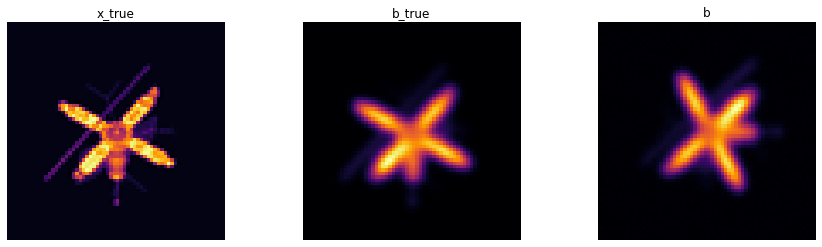

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx, ny)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx, ny)))

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

In [ ]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

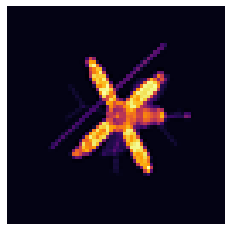

<Figure size 432x288 with 0 Axes>

In [8]:
Deblur.plot_rec(x_true.reshape((shape), order = 'F'), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)

In [15]:
from trips.solvers.GMRES import *
xx = GMRES(A, b, 4, dp_stop = 0)

generating basis...: 100%|██████████| 5/5 [00:00<00:00, 172.11it/s]
/Users/mirjetapasha/Documents/Research_Projects/TRIPS_Oct12/tripspy/trips/solvers/GMRES.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = np.linalg.lstsq(H.T, H.T@bhat)[0]


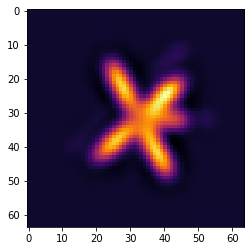

In [16]:
plt.imshow(xx.reshape((64, 64)))

Step 2: Solve the least-squares problem
$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2$

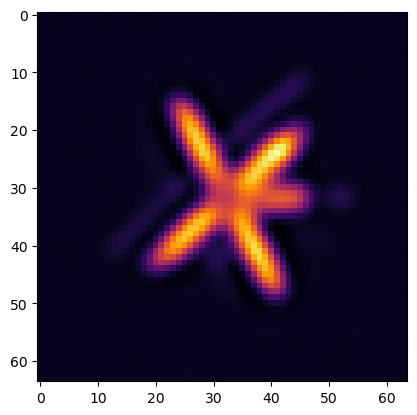

In [4]:
alpha = 0.1
b_vec = b.reshape((-1,1))
L = np.identity(A.shape[1], dtype='float32')
xTik = np.linalg.solve(A.T@A + alpha*L.T@L, A.T@b_vec)
plt.imshow((xTik.reshape((imagesize_x, imagesize_x))))

In [5]:
xx = Tikhonov(A, b_vec, L, x_true, regparam = 'gcv')

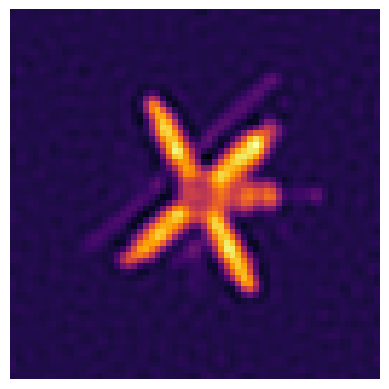

<Figure size 640x480 with 0 Axes>

In [6]:
Deblur.plot_rec(xx.reshape((64,64)), save_imgs = True, save_path='./saveImagesDeblurring')

Analyze the singular value expansion of the forward operator

generating basis...:   0%|          | 0/50 [00:00<?, ?it/s]

generating basis...: 100%|██████████| 50/50 [00:00<00:00, 68.33it/s] 


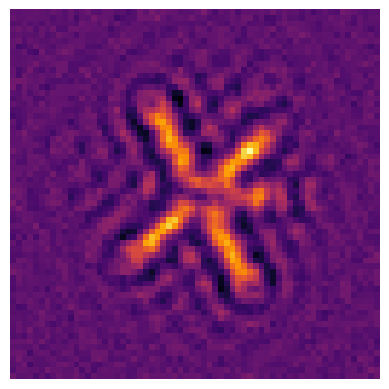

35.965515059066306

<Figure size 640x480 with 0 Axes>

In [24]:
##Unregularized Arnoldi
##Arnoldi here
projection_dim = 50
(V,H) = arnoldi(A, b_vec, projection_dim)
UU = V[:, 0:-1]
HH = H[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_Arnoldi_tikh = UU.dot(y_tikh)
Deblur.plot_rec(x_Arnoldi_tikh.reshape(imagesize_x, imagesize_y))
np.linalg.norm(x_Arnoldi_tikh-x_true.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))


generating basis...:   0%|          | 0/50 [00:00<?, ?it/s]

generating basis...: 100%|██████████| 50/50 [00:00<00:00, 106.92it/s]


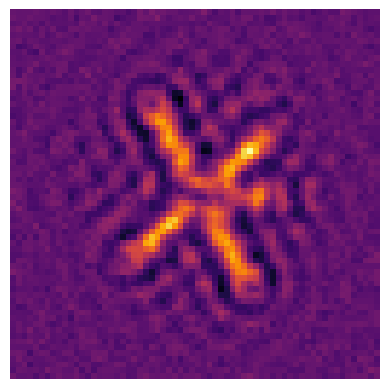

29.228099201701305

<Figure size 640x480 with 0 Axes>

In [26]:
## Regularized Arnoldi here
projection_dim = 50
(V,H) = arnoldi(A, b_vec, projection_dim)
UU = V[:, 0:-1]
HH = H[0:-1, :]
reg_param = 10
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH + reg_param*np.ones((HH.T.shape[0],HH.T.shape[0])), HH.T@bhat)
x_Arnoldi_tikh = UU.dot(y_tikh)
Deblur.plot_rec(x_Arnoldi_tikh.reshape(imagesize_x, imagesize_y))
np.linalg.norm(x_Arnoldi_tikh-x_true.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))

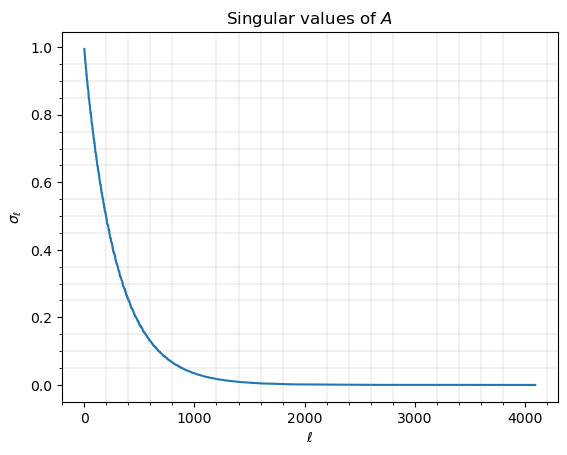

In [11]:
U, S, VT = np.linalg.svd(A)
V = VT.T
plt.plot(S)
plt.title('Singular values of $A$')
plt.xlabel('$\ell$')
plt.ylabel('$\sigma_{\ell}$')
plt.minorticks_on()
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
plt.savefig('singular_values.png', bbox_inches='tight')
plt.show()

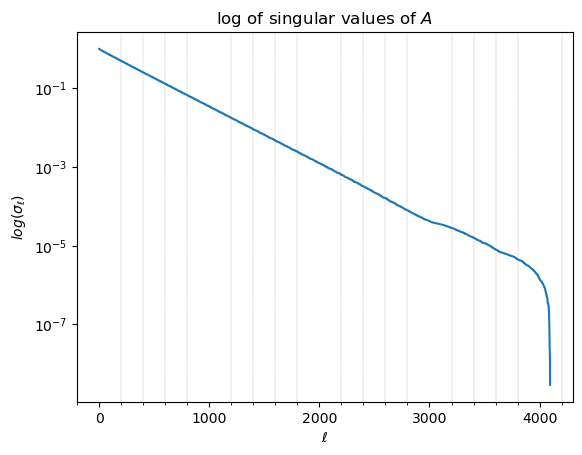

In [12]:
U, S, VT = np.linalg.svd(A)
V = VT.T
plt.semilogy(S)
plt.title('log of singular values of $A$')
plt.xlabel('$\ell$')
plt.ylabel('$log(\sigma_{\ell})$')
plt.minorticks_on()
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
plt.savefig('logsingular_values.png', bbox_inches='tight')
plt.show()

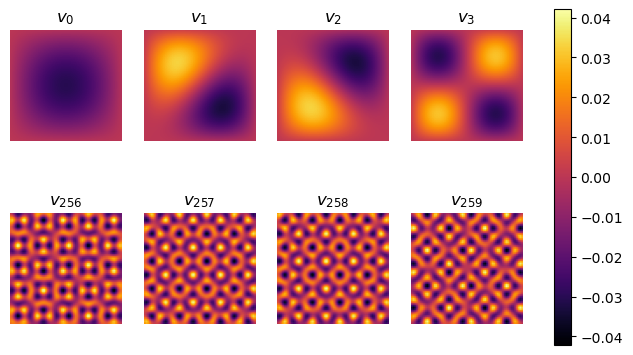

In [13]:
## Plotting the singular vectors here
n = 2
m = 4
fig, axes = plt.subplots(n, m)
v_i = [V[:, k] for k in range(m)]
v_i += [V[:, k] for k in range(128, 128+m)]
right_singular = np.array(v_i)
immax = np.max(right_singular)
immin = np.min(right_singular)
k = 0
for i in range(n):
    for j in range(m):
        image = axes[i][j].imshow(-V[:, k].reshape(size, size), vmin=immin, vmax=immax, cmap='inferno')
        axes[i][j].axis('off')
        axes[i][j].set_title(r'$v_{' + str(k) + r'}$')
        k += 1
    k = 256
plt.subplots_adjust(bottom=0, top=0.7, left = 0, right=1)
fig.colorbar(image, ax=axes.ravel().tolist())
plt.savefig('v_vectors.png', bbox_inches='tight')
plt.show()

## Compute the truncated SVD solution

In [14]:
x_tsvd = TruncatedSVD_sol(A, 20, b_vec)

In [15]:
error = np.linalg.norm(x_tsvd.reshape((-1,1)) - x_true.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))
error

0.750108311991765

(-0.5, 63.5, 63.5, -0.5)

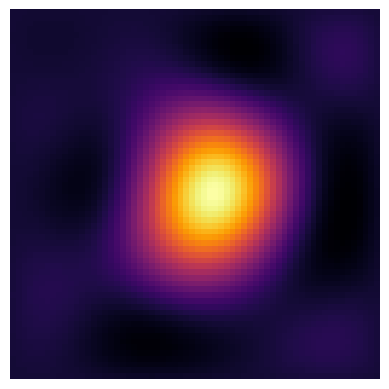

In [16]:
plt.imshow(x_tsvd.reshape((64,64)))
plt.axis('off')

In [17]:
b = b_vec
lamb = 1/16
minerror = 10000
lambdas = []
xnorms = []
residuals = []
while lamb > 1e-7:
    F = np.array([s/(s**2 + lamb**2) for s in S])
    x_reg = V @ np.diag(F) @ U.T @ b
    lambdas.append(lamb)
    xnorms.append(np.linalg.norm(x_reg))
    residuals.append(np.linalg.norm(A @ x_reg - b))
    error = np.linalg.norm(x_reg - x_true)/np.linalg.norm(x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        minx = x_reg
        minxnorm = xnorms[-1]
        minresidual = residuals[-1]
    lamb /= 2
l_curve = list(zip(lambdas, residuals, xnorms))
print('Minima:')
print('Lambda   = ', minlamb)
print('residual = ', minresidual)
print('error   = ', minerror)
print('x_norm   = ', minxnorm)

Minima:
Lambda   =  0.0625
residual =  0.136655531886623
error   =  84.53483644282984
x_norm   =  12.953812258975743


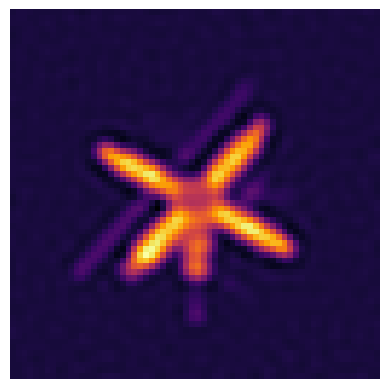

<Figure size 640x480 with 0 Axes>

In [18]:
Deblur.plot_rec(minx.reshape(shape, order = 'F'), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [19]:
def FirstDerOperator_1D(n):
    d = np.ones(n-1)
    D = np.diag(d,-1)
    L = np.identity(n)-D
    return L
# construct regularization matrix of first derivative operator 2D
def FirstDerOperator_2D(n):
    L1 = FirstDerOperator_1D(n)
    KP1 = np.kron(np.identity(n), L1)
    KP2 = np.kron(L1, np.identity(n))
    L = np.vstack((KP1, KP2))
    return L
# L = spatial_derivative_operator(imagesize_x, imagesize_y, 1)
L = FirstDerOperator_2D(shape[0])


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. 

In [20]:
xx = Tikhonov(A, b_vec, L, x_true, 'gcv')

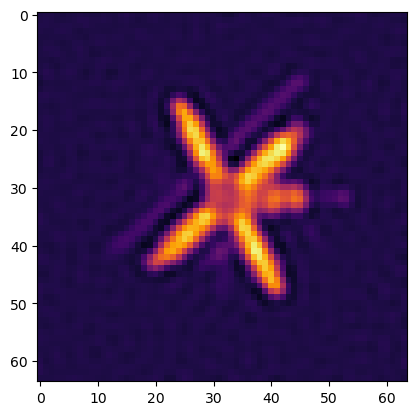

In [21]:
plt.imshow(xx.reshape(64,64))


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2]. We let $p=1$ here.

In [5]:
from trips.solvers.gks_all import *
# MMGKS(A, b, L, pnorm=1, qnorm=1, projection_dim=3, iter=50, regparam='gcv', x_true=None, **kwargs):
xhat = MMGKS(A, b_vec, L, pnorm = 2, qnorm = 1, projection_dim= 2, iter = 20, regparam = 'dp', delta = delta)
    #    GKS(A, b, L, projection_dim=3, iter=50, selection_method = 'gcv', **kwargs):

NameError: name 'b_vec' is not defined

In [10]:
class Deblurring11:
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def Gauss(self, PSFdim, PSFspread):
        self.m = PSFdim[0]
        self.n = PSFdim[1]
        self.dim = PSFdim
        self.spread = PSFspread
        self.s1, self.s2 = PSFspread, PSFspread
        # Set up grid points to evaluate the Gaussian function
        x = np.arange(-np.fix(self.n/2), np.ceil(self.n/2))
        y = np.arange(-np.fix(self.m/2), np.ceil(self.m/2))
        X, Y = np.meshgrid(x, y)
        # Compute the Gaussian, and normalize the PSF.
        PSF = np.exp( -0.5* ((X**2)/(self.s1**2) + (Y**2)/(self.s2**2)) )
        PSF /= PSF.sum()
        # find the center
        mm, nn = np.where(PSF == PSF.max())
        center = np.array([mm[0], nn[0]])   
        return PSF, center.astype(int)
    def forward_Op(self, dim, spread, nx, ny):
        PSF, center = self.Gauss(dim, spread)
        proj_forward = lambda X: convolve(X.reshape([nx,ny]), PSF, mode='constant').reshape((-1,1))
        proj_backward = lambda B: convolve(B.reshape([nx,ny]), np.flipud(np.fliplr(PSF)), mode='constant' ).reshape((-1,1))
        blur = pylops.FunctionOperator(proj_forward, proj_backward, nx*ny)
        return blur
    def generate_true(self, choose_image):
        # Specify the path
        path_package = '/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package'
        if choose_image == 'satellite128':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite128.mat')
            X = dataa['x_true']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'satellite64':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite64.mat')
            X = dataa['x_new']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'edges':
            dataa = spio.loadmat(path_package + '/demos/data/images/edges.mat')
            X = dataa['x']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'pattern1':
            dataa = spio.loadmat(path_package + '/demos/data/images/shape1.mat')
            X = dataa['xtrue']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'Himage':
            dx = 10
            dy = 10
            up_width = 10
            bar_width= 5
            size = 64
            self.nx, self.ny = 64, 64
            h_im = np.zeros((size, size))
            for i in range(size):
                if i < dy or i > size-dy:
                    continue
                for j in range(size):
                    if j < dx or j > size - dx:
                        continue
                    if j < dx + up_width or j > size - dx - up_width:
                        h_im[i, j] = 1
                    if abs(i - size/2) < bar_width:
                        h_im[i, j] = 1
            x_truef = self.vec(h_im)
            # X_true = h_im
        else:
            raise ValueError("The image you requested does not exist! Specify the right name.")
        return (x_truef, self.nx, self.ny)
        ## convert a 2-d image into a 1-d vector
    def vec(self, image):
        sh = image.shape
        return image.reshape((sh[0]*sh[1]))
    ## convert a 1-d vector into a 2-d image of the given shape
    def im(self, x, shape):
        return x.reshape(shape)
    ## display a 1-d vector as a 2-d image
    def display_vec(self, vec, shape, scale = 1):
        image = self.im(vec, shape)
        plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
        plt.axis('off')
        plt.show()
        ## a helper function for creating the blurring operator
    def get_column_sum(self, spread):
        length = 40
        raw = np.array([np.exp(-(((i-length/2)/spread[0])**2 + ((j-length/2)/spread[1])**2)/2) 
                        for i in range(length) for j in range(length)])
        return np.sum(raw[raw > 0.0001])
    ## blurs a single pixel at center with a specified Gaussian spread
    def P(self, spread, center, shape):
        image = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                v = np.exp(-(((i-center[0])/spread[0])**2 + ((j-center[1])/spread[1])**2)/2)
                if v < 0.0001:
                    continue
                image[i,j] = v
        return image

    def forward_Op_matrix(self, spread, shape, nx, ny):
        ## construct our blurring matrix with a Gaussian spread and zero boundary conditions
        #normalize = get_column_sum(spread)
        m = shape[0]
        n = shape[1]
        A = np.zeros((m*n, m*n))
        count = 0
        self.spread = spread
        self.shape = shape
        for i in range(m):
            for j in range(n):
                column = self.vec(self.P(spread, [i, j],  shape))
                A[:, count] = column
                count += 1
        normalize = np.sum(A[:, int(m*n/2 + n/2)])
        A = 1/normalize * A
        return A

    def generate_data(self, x, matrix):
        if matrix == False:
            A = self.forward_Op(self.dim, self.spread, self.nx, self.ny)
            b = A*x
        else:
            A = self.forward_Op_matrix(self.spread, self.shape, self.nx, self.ny)
            b = A@x
        return b
        
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            e = np.random.randn(self.nx*self.ny, 1)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny))
        if (opt == 'Poisson'):
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_im = b_meas.reshape((self.nx, self.ny))
            e = 0
            delta = np.linalg.norm(e)
        if (opt == 'Laplace'):
            e = np.random.laplace(self.nx*self.ny)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny), order='F')
        return (b_meas_im, delta)

In [12]:
(b, delta) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.01)

In [11]:
# Deblurring example test problem
Deblur = Deblurring11()
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
nx = 64 # Define the first dimension of the image
ny = 64 # Define the second dimension of the image
spread = 1.5 # The PSF parameter
choose_image = 'satellite64' #The choice of the image
if generate_matrix == True:
        shape = (nx, ny)
        spreadnew = (spread, spread)
        A = Deblur.forward_Op_matrix(spreadnew, shape, nx, ny)
(x_true, nx, ny) = Deblur.generate_true(choose_image)
b_true = Deblur.generate_data(x_true, generate_matrix)
# (b, delta) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.01)
# Deblur.plot_rec(b.reshape((shape), order = 'F'), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)